# Change backbone to MobileNet
### First, setup libraries

In [10]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# plt.rcParams['text.usetex'] = True  # Render Matplotlib text with Tex
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

### Prepare data

In [11]:
# Define the data to be used
DATASET = "./datasets/dataset_3+8bags_3var3sc/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [12]:
def compute_mean_std(images_directory, traversal_costs_file):
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [13]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3426, 0.3569, 0.2914]) tensor([0.1363, 0.1248, 0.1302])


In [14]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [15]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [16]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


### GPU?

In [17]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cpu



### Model design and initialization

In [18]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Load the pre-trained MobileNet model
model = models.mobilenet_v2(pretrained=True).to(device=device)

# Replace the last layer by a fully-connected one with 1 output
model.classifier[1] = nn.Linear(model.last_channel, 1).to(device=device)

# Initialize the last layer using Xavier initialization
nn.init.xavier_uniform_(model.classifier[1].weight)

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels = next(iter(train_loader))
images = images.to(device)
tensorboard.add_graph(model, images)

# Print the modified model
print(model)


/home/sabrina-pecka/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sabrina-pecka/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [19]:
[(name, param.shape) for name, param in model.named_parameters()]

[('features.0.0.weight', torch.Size([32, 3, 3, 3])),
 ('features.0.1.weight', torch.Size([32])),
 ('features.0.1.bias', torch.Size([32])),
 ('features.1.conv.0.0.weight', torch.Size([32, 1, 3, 3])),
 ('features.1.conv.0.1.weight', torch.Size([32])),
 ('features.1.conv.0.1.bias', torch.Size([32])),
 ('features.1.conv.1.weight', torch.Size([16, 32, 1, 1])),
 ('features.1.conv.2.weight', torch.Size([16])),
 ('features.1.conv.2.bias', torch.Size([16])),
 ('features.2.conv.0.0.weight', torch.Size([96, 16, 1, 1])),
 ('features.2.conv.0.1.weight', torch.Size([96])),
 ('features.2.conv.0.1.bias', torch.Size([96])),
 ('features.2.conv.1.0.weight', torch.Size([96, 1, 3, 3])),
 ('features.2.conv.1.1.weight', torch.Size([96])),
 ('features.2.conv.1.1.bias', torch.Size([96])),
 ('features.2.conv.2.weight', torch.Size([24, 96, 1, 1])),
 ('features.2.conv.3.weight', torch.Size([24])),
 ('features.2.conv.3.bias', torch.Size([24])),
 ('features.3.conv.0.0.weight', torch.Size([144, 24, 1, 1])),
 ('featu

### Training and validation loops

In [20]:
# Define the loss function
criterion = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["classifier.1.weight", "classifier.1.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.classifier.parameters(), "lr": 1e-3},
],
    lr=1e-3, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 100

# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0

loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, _ in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, _ in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversal_costs = model(images)

            # Compute loss
            loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
    
    # Compute the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    
    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Close TensorBoard
tensorboard.close()


Epoch 0 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.87batch/s, batch_loss=0.129] 


Train loss:  0.5503814800809591
Validation loss:  0.10920764000288077


Epoch 1 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.90batch/s, batch_loss=0.0548]


Train loss:  0.10795900300145149
Validation loss:  0.06530301672007356


Epoch 2 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.28batch/s, batch_loss=0.0688]


Train loss:  0.08342016232319367
Validation loss:  0.0678469669960794


Epoch 3 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.10batch/s, batch_loss=0.1]   


Train loss:  0.06724626591954476
Validation loss:  0.11696862376161984


Epoch 4 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.52batch/s, batch_loss=0.08]  


Train loss:  0.06813964085319103
Validation loss:  0.07617422636775743


Epoch 5 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.75batch/s, batch_loss=0.0446]


Train loss:  0.05878706513307033
Validation loss:  0.056184545602826846


Epoch 6 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.73batch/s, batch_loss=0.0602]


Train loss:  0.055381340781847636
Validation loss:  0.058123361674093064


Epoch 7 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.54batch/s, batch_loss=0.0893]


Train loss:  0.05326916420688996
Validation loss:  0.06092605234256813


Epoch 8 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.73batch/s, batch_loss=0.0364]


Train loss:  0.05463072530543193
Validation loss:  0.049453258026568664


Epoch 9 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.71batch/s, batch_loss=0.0171]


Train loss:  0.049621169421917355
Validation loss:  0.06137178793904327


Epoch 10 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.98batch/s, batch_loss=0.0296]


Train loss:  0.050873858462541534
Validation loss:  0.05316009341428677


Epoch 11 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.88batch/s, batch_loss=0.118] 


Train loss:  0.047414944951350874
Validation loss:  0.04810056538276729


Epoch 12 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.72batch/s, batch_loss=0.0421]


Train loss:  0.046761422843123096
Validation loss:  0.061077975313223544


Epoch 13 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.56batch/s, batch_loss=0.0558]


Train loss:  0.04626707755602323
Validation loss:  0.058891297495436104


Epoch 14 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.16batch/s, batch_loss=0.0482]


Train loss:  0.04603546295219507
Validation loss:  0.0472119924656692


Epoch 15 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.84batch/s, batch_loss=0.0734]


Train loss:  0.04619852696091701
Validation loss:  0.060587740769343715


Epoch 16 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.82batch/s, batch_loss=0.0524]


Train loss:  0.04489909565697114
Validation loss:  0.0518036676304681


Epoch 17 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.33batch/s, batch_loss=0.0556]


Train loss:  0.04432942606986333
Validation loss:  0.05748663212926615


Epoch 18 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.77batch/s, batch_loss=0.117] 


Train loss:  0.04600746881407805
Validation loss:  0.0527166390702838


Epoch 19 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.53batch/s, batch_loss=0.0187]


Train loss:  0.04398995537597399
Validation loss:  0.04437403655832722


Epoch 20 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.85batch/s, batch_loss=0.0183]


Train loss:  0.04367766984475729
Validation loss:  0.045402788202322665


Epoch 21 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.81batch/s, batch_loss=0.0522]


Train loss:  0.042478261983547455
Validation loss:  0.04909683129794541


Epoch 22 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.13batch/s, batch_loss=0.0258]


Train loss:  0.04326936520445041
Validation loss:  0.046461541161295916


Epoch 23 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.97batch/s, batch_loss=0.0385]


Train loss:  0.041524246970239355
Validation loss:  0.06139469026987042


Epoch 24 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.51batch/s, batch_loss=0.0296]


Train loss:  0.04644128382683564
Validation loss:  0.04636601327608029


Epoch 25 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.90batch/s, batch_loss=0.0267]


Train loss:  0.042796600557481634
Validation loss:  0.04650563063720862


Epoch 26 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.54batch/s, batch_loss=0.0679]


Train loss:  0.04256057304640611
Validation loss:  0.0546320579679949


Epoch 27 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.65batch/s, batch_loss=0.0408]


Train loss:  0.04228672868548296
Validation loss:  0.05017982982099056


Epoch 28 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.48batch/s, batch_loss=0.0612]


Train loss:  0.04195936177499019
Validation loss:  0.045141229450347875


Epoch 29 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.01batch/s, batch_loss=0.0335]


Train loss:  0.03987619121296283
Validation loss:  0.044259675024520787


Epoch 30 [val]: 100%|██████████| 42/42 [00:03<00:00, 13.04batch/s, batch_loss=0.0343]


Train loss:  0.040576990187550205
Validation loss:  0.04467358608685788


Epoch 31 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.54batch/s, batch_loss=0.042] 


Train loss:  0.04110787682330761
Validation loss:  0.04500859252931107


Epoch 32 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.67batch/s, batch_loss=0.0468]


Train loss:  0.040397318423940586
Validation loss:  0.04644036040242229


Epoch 33 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.93batch/s, batch_loss=0.0207]


Train loss:  0.04076001653686548
Validation loss:  0.041030784647556995


Epoch 34 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.47batch/s, batch_loss=0.0267]


Train loss:  0.03776502319348928
Validation loss:  0.04068341356746498


Epoch 35 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.31batch/s, batch_loss=0.0406]


Train loss:  0.038692549348641664
Validation loss:  0.04455896081136806


Epoch 36 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.59batch/s, batch_loss=0.0449]


Train loss:  0.039261959679424766
Validation loss:  0.04343437727185942


Epoch 37 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.44batch/s, batch_loss=0.0224]


Train loss:  0.03920960723398588
Validation loss:  0.042970122813823675


Epoch 38 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.21batch/s, batch_loss=0.0243]


Train loss:  0.03804948465564312
Validation loss:  0.039520958660259134


Epoch 39 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.05batch/s, batch_loss=0.0297]


Train loss:  0.03784659191583976
Validation loss:  0.04147768481856301


Epoch 40 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.00batch/s, batch_loss=0.0842]


Train loss:  0.044309490465391906
Validation loss:  0.042232083600191844


Epoch 41 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.86batch/s, batch_loss=0.024] 


Train loss:  0.041028032704996754
Validation loss:  0.045726324431598186


Epoch 42 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.16batch/s, batch_loss=0.0534]


Train loss:  0.03887144715931171
Validation loss:  0.045534271214689524


Epoch 43 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.98batch/s, batch_loss=0.032] 


Train loss:  0.038306112324771206
Validation loss:  0.04258461096989257


Epoch 44 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.73batch/s, batch_loss=0.0723]


Train loss:  0.03906431449816013
Validation loss:  0.04057460908024084


Epoch 45 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.42batch/s, batch_loss=0.0231]


Train loss:  0.03709582231031396
Validation loss:  0.04167862116758313


Epoch 46 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.59batch/s, batch_loss=0.0217]


Train loss:  0.037384032868804075
Validation loss:  0.039804689009629544


Epoch 47 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.97batch/s, batch_loss=0.0294]


Train loss:  0.03751618023484181
Validation loss:  0.045237254129634016


Epoch 48 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.49batch/s, batch_loss=0.0504]

Train loss:  0.03715337720723488
Validation loss:  0.03990488774364903
Early stopping at epoch 48


### Visualization

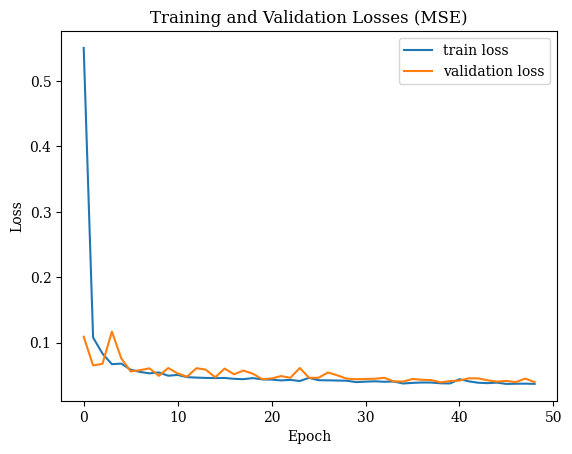

In [26]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses (MSE)")
plt.show()

### Testing

In [28]:
# Testing
test_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, _ in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
# Compute the loss and accuracy
test_loss /= len(test_loader)

print("Test loss: ", test_loss)

Test loss:  0.04202291613457861


In [29]:
images, traversal_costs, _ = next(iter(test_loader))

images = images.to(device)
traversal_costs = traversal_costs.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_costs)
print("Ground truth:\n", traversal_costs)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)

Output:
 tensor([[1.8670],
        [1.2806],
        [1.8940],
        [1.7437],
        [1.8482],
        [1.7804],
        [1.8769],
        [1.9111],
        [1.8575],
        [1.8418],
        [1.8656],
        [1.2047],
        [1.8851],
        [1.8805],
        [1.4434],
        [1.9389],
        [1.3654],
        [1.8229],
        [1.8786],
        [1.5522],
        [1.8413],
        [1.6429],
        [1.5012],
        [1.7608],
        [1.8276],
        [1.3925]])
Ground truth:
 tensor([1.4431, 1.8142, 1.4213, 1.8988, 1.6864, 1.0896, 1.3164, 1.1830, 1.9168,
        1.0740, 1.7578, 1.9497, 1.1054, 1.4927, 2.1730, 1.6349, 1.9143, 1.6020,
        1.8331, 2.0072, 1.7344, 1.1041, 1.8847, 1.4045, 0.9980, 2.2835, 1.8514,
        1.1247, 2.0487, 1.2955, 1.9082, 1.9524], dtype=torch.float64)


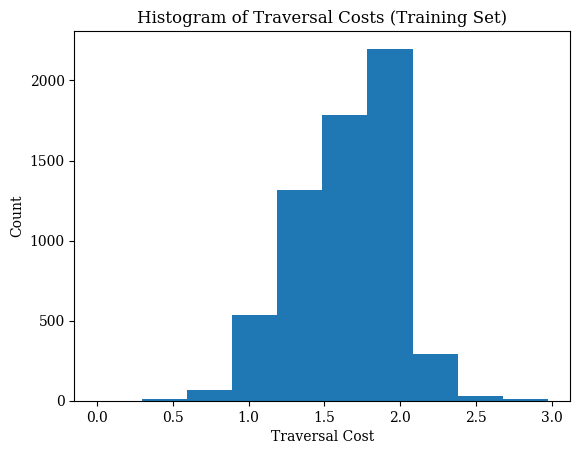

In [38]:
traversal_costs_train = []

for _, score, _ in train_set:
    traversal_costs_train.append(score)
    
plt.hist(traversal_costs_train, bins=10)
plt.xlabel("Traversal Cost")
plt.ylabel("Count")
plt.title("Histogram of Traversal Costs (Training Set)")
plt.show()


### Save model parameters

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), "mobilenet.params")